## Semantic Segmentation


### Class Heatmap
![Heatmap](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSRd6rCHDMj1Yf8lrDD5in14daoDyegD-EfCI6fwU7dSD9VB9OW)

### Different CV Tasks
![CVTasks](https://miro.medium.com/max/2000/1*cHtBw8yBhprNXj-CBQBx5g.png)

# CAMVID
[CAMVID](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) is dataset by Cambridge 
_"The Cambridge-driving Labeled Video Database (CamVid) is the first collection of videos with object class semantic labels_

It has 701 RGB images (960x720), and their corresponding ground truth masks.
It has 32 classes, where each pixel is labeled according to 1 of 32 colors. This is called per-pixel semantic segmentation (vs. instance segmentation as described above).

The colors mapping can be found in a separate [file](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/data/label_colorsSorted.txt).

The ground truth are represented as colored images, where each pixel color corresponds to a class according to the mapping in the file.

To get all the files, you can get the labels (masks images) from this [link](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/data/LabeledApproved_full.zip)

__However, to get the corresponding images, you need to run a script to extract the frames from few video sequences (like CamSeq01)__

__Under this nice [repo](https://github.com/GeorgeSeif/Semantic-Segmentation-Suite), the author has already done that for us, and split the data into train/val/test already. We're going to use that.__

In [ ]:
view = 0
batch_sz = 4
epochs = 1
steps_per_epoch = 1000
validation_steps = 100

``` bash
## cloning the repo ---> which handle the CAMVID dataset 
!git clone https://github.com/GeorgeSeif/Semantic-Segmentation-Suite.git
```

In [ ]:
import os

In [ ]:
from pathlib import Path
data_path = Path('Semantic-Segmentation-Suite/CamVid')

In [ ]:
print('Number of train frames: ' + str(len(os.listdir(data_path/'train'))))
print('Number of train labels: ' + str(len(os.listdir(data_path/'train_labels'))))
print('Number of val frames: ' + str(len(os.listdir(data_path/'val'))))
print('Number of val labels: ' + str(len(os.listdir(data_path/'val_labels'))))
print('Number of test frames: ' + str(len(os.listdir(data_path/'test'))))
print('Number of test labels: ' + str(len(os.listdir(data_path/'test_labels'))))
print('Total frames: ' + str(len(os.listdir(data_path/'train')) + len(os.listdir(data_path/'val')) + len(os.listdir(data_path/'test'))))

Number of train frames: 421
Number of train labels: 421
Number of val frames: 112
Number of val labels: 112
Number of test frames: 168
Number of test labels: 168
Total frames: 701


Now, let's see which classes we have. This can be found in the original CAMVID [text file](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/data/label_colors.txt). However, under the same repo, the author has dumped it into csv which we will use.

In [ ]:
import pandas as pd
classes = pd.read_csv(data_path / 'class_dict.csv', index_col =0)

In [ ]:
classes

r    g    b
name                            
Animal              64  128   64
Archway            192    0  128
Bicyclist            0  128  192
Bridge               0  128   64
Building           128    0    0
Car                 64    0  128
CartLuggagePram     64    0  192
Child              192  128   64
Column_Pole        192  192  128
Fence               64   64  128
LaneMkgsDriv       128    0  192
LaneMkgsNonDriv    192    0   64
Misc_Text          128  128   64
MotorcycleScooter  192    0  192
OtherMoving        128   64   64
ParkingBlock        64  192  128
Pedestrian          64   64    0
Road               128   64  128
RoadShoulder       128  128  192
Sidewalk             0    0  192
SignSymbol         192  128  128
Sky                128  128  128
SUVPickupTruck      64  128  192
TrafficCone          0    0   64
TrafficLight         0   64   64
Train              192   64  128
Tree               128  128    0
Truck_Bus          192  128  192
Tunnel              64    0   64
VegetationMisc     192  192    0
Void                 0    0    0
Wall                64  192    0

In [ ]:
n_classes = len(classes)
n_classes

32

This data frame maps the class names to colors.

To access the colors, we can index the dataframe with its row index name using the .loc operation.


Now we are ready to create a map from class name to color

In [ ]:
cls2rgb = {cl:list(classes.loc[cl, :]) for cl in classes.index}

### Now let's visualize and explore some samples:

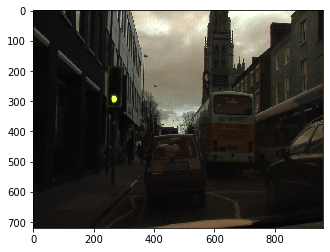

In [ ]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
#from google.colab.patches import  cv2_imshow

#img = cv2.imread(data_path/'train/0001TP_006690.png')
img = cv2.imread(str(data_path) + '/train/0001TP_006690.png')
plt.imshow(img)

Let's have a look on the masks (the ground truth)

As you can see the masks are just colors (L,W,3).
What we actually want is a (L,W) matrix, with each value is from 0 to 31 representing the 32 class labels.

Colors are different from the colors in cls2rgb! Because the order is BGR not RGB when using cv2.imread: https://stackoverflow.com/questions/46898979/how-to-check-the-channel-order-of-an-image

If you want to get the same order as in the color mapping of CAMVID, use the cv converted

In [ ]:
import numpy as np
mask = cv2.imread(str(data_path) + '/train_labels/0001TP_006690_L.png')
mask = cv2.cvtColor((mask).astype(np.uint8), cv2.COLOR_BGR2RGB)# If you want to get the same order as in the color mapping of CAMVID, use the cv converted

Now if you plot the mask again, you will see different colors. For example the red and blue are reversed than before:

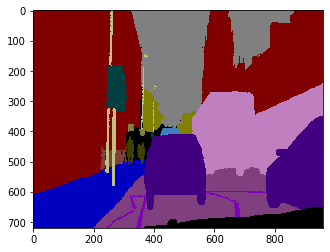

In [ ]:
plt.imshow(mask)

Another solution is to use load_image from keras which uses RGB (it uses PIL under the hood) unlike cv2.imread

Using TensorFlow backend.


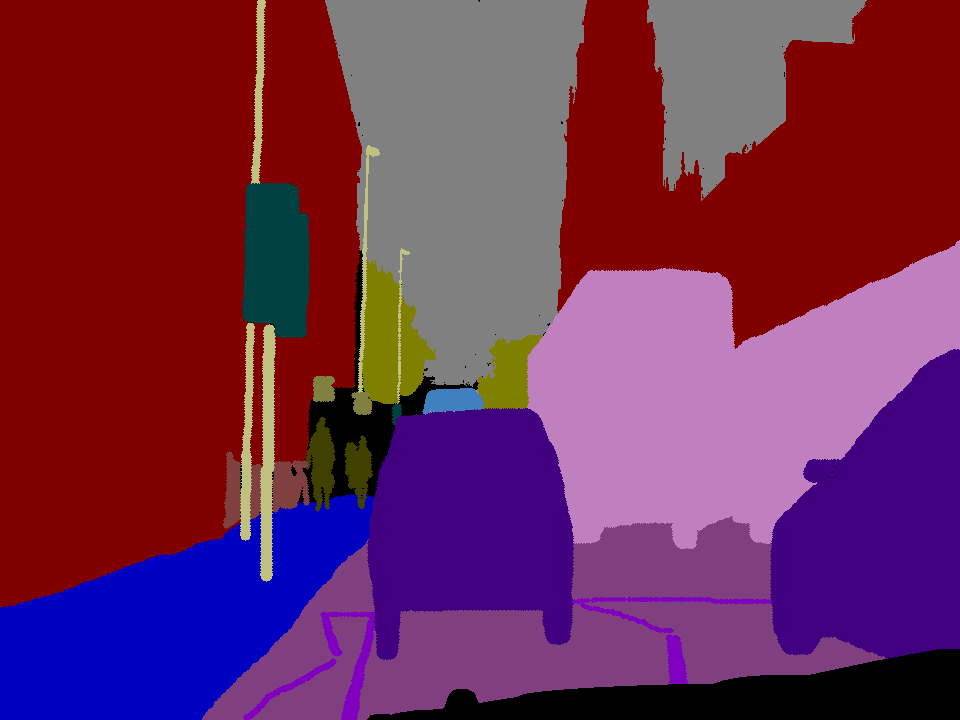

In [ ]:
from keras.preprocessing.image import load_img
mask = load_img(str(data_path) + '/train_labels/0001TP_006690_L.png')
mask

In [ ]:
mask = np.array(mask)# Now colors are the same as in the dict, since keras load_img uses RGB order.

In [ ]:
mask.shape

(720, 960, 3)

# Masks labels adjustment
Now to perform the mapping, we want to apply a mapping using on every pixel.
We can create a dict from color to indx (rgb2idx) and apply it on all pixels.
It can be done using the apply_along_axis operation, but takes very long. 

In [ ]:
def adjust_mask(mask, flat=False):
    
    semantic_map = []
    for colour in list(cls2rgb.values()):        
        equality = np.equal(mask, colour)# 256x256x3 with True or False
        class_map = np.all(equality, axis = -1)# 256x256 If all True, then True, else False
        semantic_map.append(class_map)# List of 256x256 arrays, map of True for a given found color at the pixel, and False otherwise.
    semantic_map = np.stack(semantic_map, axis=-1)# 256x256x32 True only at the found color, and all False otherwise.
    if flat:
      semantic_map = np.reshape(semantic_map, (-1,256*256))

    return np.float32(semantic_map)# convert to numbers

In [ ]:
new_mask = adjust_mask(mask)

In [ ]:
new_mask.shape

(720, 960, 32)

To make sure we performed the mapping correctly, let's try to do the reverse mapping.
Note that, we will need this later when we get predictions from our network and we want to view it as RGB mask like the original data labels.

First, we want to create the reverse mapping from class index to RGB color. Again we use dict comprehensions:

In [ ]:
idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())}


This time we have a (L,W,32) mask and we want to map it to color mask (L,W,3). First we need to map it to index map using np.argmax, then use idx2rgb to restore the color back

In [ ]:
# Map the idx back to rgb
def map_class_to_rgb(p):
  
  return idx2rgb[p[0]]

rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(new_mask, axis=-1), -1))

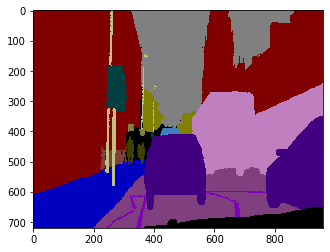

In [ ]:
plt.imshow(rgb_mask)

# Model
__U-Net__

We will investigate a famous model called U-Net

![U Net](https://lmb.informatik.uni-freiburg.de/Publications/2015/RFB15a/u-net-architecture.png)



In [ ]:
import numpy as np 
import os
#import skimage.io as io
#import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(n_classes, pretrained_weights = None,input_size = (256,256,3), flat=False, ohe=True):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    x = UpSampling2D(size = (2,2))(drop5)
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv10 = Conv2D(n_classes, (1,1), activation = 'softmax')(conv9)
    conv10 = Conv2D(n_classes, (1,1), padding='same')(conv9)
    if flat:
      output_layer = Reshape((256*256,n_classes))(conv10)
    else:
      output_layer = conv10
    output_layer = Activation('softmax')(output_layer)
     

    model = Model(input = inputs, output = output_layer)

    if ohe:
      model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    else:
      model.compile(optimizer = Adam(lr = 1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model



In [ ]:

model = unet(n_classes)
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           co

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


# Data in RAM
One option is to perform the above operation over all the data files masks, and load them all in RAM.



You must sort the files, otherwise you get wrong GT to mask mapping

You don't need to get the same file name, in the 2 folders, as we can sort by name. The only difference in img and mask name is _L.png

In [ ]:
def load_CAMVID(data_type='train', enc='ohe', shape='normal'):
  img_path = str(data_path) + '/' + data_type + '/'
  labels_path = str(data_path) + '/' + data_type + '_labels/'
  # without adding target_size=(256,256) in load_img we get Out of mem: 421x960x720x32x4bytes is around 34GB!
  x = np.array([np.array(load_img(str(img_path) + file, target_size=(256,256)))*1./255 for file in sorted(os.listdir(img_path))])
  if(enc=='ohe'):
    
    y = np.array([adjust_mask(np.array(load_img(str(labels_path) + file, target_size=(256,256)))) for file in sorted(os.listdir(labels_path))])
  elif(enc=='sparse_cat'):
    y = np.array([adjust_mask(np.array(load_img(str(labels_path) + file, target_size=(256,256)))) for file in sorted(os.listdir(labels_path))])
  if(shape == 'flat'):
    y = np.reshape(y.shape[0], y.shape[1]*y.shape[2])
    y = np.expand_dims(y, axis=-1)
  return x, y
  

In [ ]:
import time
start = time.time()
x_train, y_train = load_CAMVID(data_type='train')
#x_test, y_test = load_CAMVID(data_type='test')# Don't load test for RAM consumption
x_val, y_val = load_CAMVID(data_type='val')
end = time.time()
print('Time elapsed: ', end-start)

Time elapsed:  55.09869050979614


In [ ]:
print(x_train.shape)
print(y_train.shape)
#print(x_test.shape)
#print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(421, 256, 256, 3)
(421, 256, 256, 32)
(112, 256, 256, 3)
(112, 256, 256, 32)


# Train

In [ ]:
model_checkpoint = ModelCheckpoint('unet_camvid.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
model.fit(x=x_train, 
              y=y_train,
              validation_data=(x_val, y_val),
              batch_size=batch_sz,# 32 gives OOM sometimes
              epochs=epochs,
              callbacks=[model_checkpoint])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 421 samples, validate on 112 samples
Epoch 1/1





421/421 [==============================] - 41s 97ms/step - loss: 1.7566 - acc: 0.5362 - val_loss: 1.4116 - val_acc: 0.6136

Epoch 00001: val_loss improved from inf to 1.41158, saving model to unet_camvid.hdf5


# Let's try on some samples

In [ ]:
# img (256,256,3)
# gt_mask: gt_mode=sparse--> (256,256) or ohe --> (256,256,32)
def visualize_seg(img, gt_mask, shape='normal', gt_mode='sparse'):
  plt.figure(1)
  
  # Img
  plt.subplot(311)
  plt.imshow(img)
  
  # Predict
  pred_mask = model.predict(np.expand_dims(img, 0))
  pred_mask = np.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[0]
  if shape=='flat':
    pred_mask = np.reshape(pred_mask, (256,256)) # Reshape only if you use the flat model. O.w. you dont need
  
  rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(pred_mask, -1))
  
  # Prediction
  plt.subplot(312)
  plt.imshow(rgb_mask)
              
  # GT mask
  if gt_mode == 'ohe':
    gt_img_ohe = np.argmax(gt_mask, axis=-1)
    gt_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(gt_img_ohe, -1))              
  
  plt.subplot(313)
  plt.imshow((gt_mask).astype(np.uint8))
                
  
  

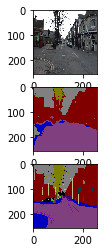

In [ ]:
visualize_seg(x_val[100], y_val[100], gt_mode='ohe')

# Load data from disk

We will explore two approaches, the first is to build our own custom loader. This method is generic, and works for both image and other data sets.

Then we will see how Keras provides a convenient way to do that for Image data.

## Custom Data loaders
Keras provides a basic generator to inherity from `keras.utils.Sequence`, we just need to implement `len` and `getitem` methods.

In [ ]:
from keras.utils import Sequence
class CAMVID_Dataset(Sequence):


    def __init__(self, data_path, batch_size=4, dim=(256,256), n_classes=32, data_type='train', shape='normal'):

        self.images_dir = str(data_path) + '/' + data_type + '/'
        self.masks_dir = str(data_path) + '/' + data_type + '_labels/'
        assert len(os.listdir(self.images_dir)) == len(os.listdir(self.masks_dir))
        self.data_type = data_type
        self.shape = shape
        self.batch_size = batch_size
        self.dim = dim
        self.n = len(os.listdir(self.images_dir))
        self.n_batches = int(np.floor(self.n  / self.batch_size))
        self.indexes = np.arange(self.n)

    def __len__(self):
        return  self.n_batches

    def __getitem__(self, index):
        X = np.empty((self.batch_size, *self.dim, 3))
        Y = np.zeros((self.batch_size, *self.dim, n_classes))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Generate data
        for i, ID in enumerate(indexes):
          idx = ID

          file = sorted(os.listdir(self.images_dir))[idx]

          # Load image
          image = np.array(load_img(str(self.images_dir) + file, target_size=(256,256)))*1./255


          # Load mask
          file = sorted(os.listdir(self.masks_dir))[idx]
          mask = adjust_mask(np.array(load_img(str(self.masks_dir) + file, target_size=(256,256))))

          if(self.shape == 'flat'):
            mask = np.reshape(mask.shape[0], mask.shape[1]*mask.shape[2])
            mask = np.expand_dims(mask, axis=-1)        
          X[i,:] = image
          Y[i,:] = mask
          
        return X, Y
      

In [ ]:
train_gen = CAMVID_Dataset(str(data_path), batch_size=batch_sz, n_classes=n_classes, data_type='train')
valid_gen = CAMVID_Dataset(str(data_path), batch_size=batch_sz, n_classes=n_classes, data_type='val')

In [ ]:
x,y = next(enumerate(train_gen))[1]
print(x.shape)
print(y.shape)

(4, 256, 256, 3)
(4, 256, 256, 32)


In [ ]:
n_train_samples = len(os.listdir(str(data_path) + '/train/'))
n_train_samples

421

In [ ]:

model = unet(n_classes)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


In [ ]:
model_checkpoint = ModelCheckpoint('unet_camvid.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
model.fit_generator(train_gen,
                    validation_data=valid_gen,
                    steps_per_epoch=n_train_samples,
                    validation_steps=validation_steps,
                    epochs=epochs,
                    callbacks=[model_checkpoint])

Epoch 1/1
421/421 [==============================] - 222s 526ms/step - loss: 1.5335 - acc: 0.5794 - val_loss: 1.1722 - val_acc: 0.6951

Epoch 00001: val_loss improved from inf to 1.17220, saving model to unet_camvid.hdf5


Next we will see how this can be automated using ImageDataGenerator, and also to include data augmentation.

_Note_ all the next steps can also be done using custom class as above.

## Using ImageDataGenerator

We won't specify any data augmentation for now.

But if we were to, we need to take care of few things:

1- __Fix the seed__ we dont want to perform an operation on the image different from the mask. But in the same time, we have two generators, one for mask and one for images (as they are different files on disk)

2- __How to ensure the label and image files correspond to each others?__ We will have mask and image generators (loaders), each points to a different folder. Moreover, the file names of the img and mask are not the same. When we loaded the data in RAM ourselves, we used sorted to ensure consistency.

In keras, sorted is used as well. See [here](https://stackoverflow.com/questions/42868982/how-do-i-check-the-order-in-which-keras-flow-from-directory-method-processes-fo)


3- When speficifying the directory to flow_from_directory, the function assumes every sub-directory corresponds to a class (see cats vs dogs tutorial). If this is not the case, no files are loaded. However, we are not doing image classification this is not applicable. 
To workaround this, we use the train, val, test folders as if they are class folders, using the parameter `classes`



In [ ]:
# Data generator
#https://keras.io/preprocessing/image/
# Data generator
#batch_sz = 4

from keras.preprocessing.image import ImageDataGenerator
# we create two instances with the same arguments

# VI Note: use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
data_gen_args = dict(rescale=1./255)

# So our usage here is as data loader instead of loading everything in RAM, not data augmentation
mask_gen_args = dict()

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**mask_gen_args) 

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
#image_datagen.fit(images, augment=True, seed=seed)
#mask_datagen.fit(masks, augment=True, seed=seed)

image_generator = image_datagen.flow_from_directory(
    data_path,
    class_mode=None,
    classes=['train'],
    seed=seed,
    batch_size=batch_sz,
    target_size=(256,256))

mask_generator = mask_datagen.flow_from_directory(
    data_path,
    classes=['train_labels'],
    class_mode=None,
    seed=seed,
    color_mode='rgb',
    batch_size=batch_sz,
    target_size=(256,256))

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

      

val_image_generator = image_datagen.flow_from_directory(
    data_path,
    class_mode=None,
    classes=['val'],
    seed=seed,
    batch_size=batch_sz,
    target_size=(256,256))

val_mask_generator = mask_datagen.flow_from_directory(
    data_path,
    classes=['val_labels'],
    class_mode=None,
    seed=seed,
    batch_size=batch_sz,
    color_mode='rgb',
    target_size=(256,256))

# combine generators into one which yields image and masks
val_generator = zip(val_image_generator, val_mask_generator)

      

Found 421 images belonging to 1 classes.
Found 421 images belonging to 1 classes.
Found 112 images belonging to 1 classes.
Found 112 images belonging to 1 classes.


In [ ]:

def train_generator_fn():

    for (img,mask) in train_generator:
        new_mask = adjust_mask(mask)
        yield (img,new_mask)        

In [ ]:

def val_generator_fn():

    for (img,mask) in val_generator:
        new_mask = adjust_mask(mask)
        yield (img,new_mask)  

_steps_per_epoch: _

Remember we dont have constant data size due to augmentation and yield in the generator. If you dont have augmentation and just using flow_from_directory as a data loader, then set this to size/batch_size_

Note that, since we don't use data augmentation, we have fixed data size. In this case steps_per_epoch is just the total_size/batch_size

In [ ]:
n_train_samples = len(os.listdir(str(data_path) + '/train/'))
n_train_samples

421

In [ ]:

model = unet(n_classes)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


In [ ]:
model_checkpoint = ModelCheckpoint('unet_camvid.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
model.fit_generator(train_generator_fn(),
                    validation_data=val_generator_fn(),
                    steps_per_epoch=n_train_samples,
                    validation_steps=validation_steps,
                    epochs=epochs,
                    callbacks=[model_checkpoint])

Epoch 1/1
421/421 [==============================] - 209s 496ms/step - loss: 1.3278 - acc: 0.6511 - val_loss: 0.8943 - val_acc: 0.7620

Epoch 00001: val_loss improved from inf to 0.89425, saving model to unet_camvid.hdf5


## Let's test the model on sample images

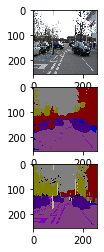

In [ ]:
visualize_seg(next(val_image_generator)[0], next(val_mask_generator)[0], gt_mode='sparse')

## Data augmentation

When doing data augmentation we have to take of few things:

1- No transform to change the pixel values of the masks. Otherwise, the colors ranges will not be found in the dict.

2- Any geometric transform must be applied equally on the mask and the img

3- Fix the seed between mask and img generators, so that the same operation is applied to both.



In [ ]:
# Data generator
#batch_sz = 4
#https://keras.io/preprocessing/image/
from keras.preprocessing.image import ImageDataGenerator
# we create two instances with the same arguments

# VI Note: use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1./255)

mask_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
                    

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**mask_gen_args) 

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
#image_datagen.fit(images, augment=True, seed=seed)
#mask_datagen.fit(masks, augment=True, seed=seed)

image_generator = image_datagen.flow_from_directory(
    data_path,
    class_mode=None,
    classes=['train'],
    seed=seed,
    batch_size=batch_sz,
    target_size=(256,256))

mask_generator = mask_datagen.flow_from_directory(
    data_path,
    classes=['train_labels'],
    class_mode=None,
    seed=seed,
    batch_size=batch_sz,
    color_mode='rgb',
    target_size=(256,256))

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

def train_generator_fn():
    for (img,mask) in train_generator:
        new_mask = adjust_mask(mask)
        yield (img,new_mask)  
        
val_image_generator = image_datagen.flow_from_directory(
    data_path,
    class_mode=None,
    classes=['val'],
    seed=seed,
    batch_size=batch_sz,
    target_size=(256,256))

val_mask_generator = mask_datagen.flow_from_directory(
    data_path,
    classes=['val_labels'],
    class_mode=None,
    seed=seed,
    batch_size=batch_sz,
    color_mode='rgb',
    target_size=(256,256))

# combine generators into one which yields image and masks
val_generator = zip(val_image_generator, val_mask_generator)        
        
def val_generator_fn():

    for (img,mask) in val_generator:
        new_mask = adjust_mask(mask)
        yield (img,new_mask)         


Found 421 images belonging to 1 classes.
Found 421 images belonging to 1 classes.
Found 112 images belonging to 1 classes.
Found 112 images belonging to 1 classes.




Let's take a look on some augmented images and masks

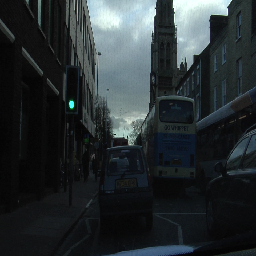

In [ ]:
img = load_img(str(data_path) + '/train/0001TP_006690.png', target_size=(256,256))
img

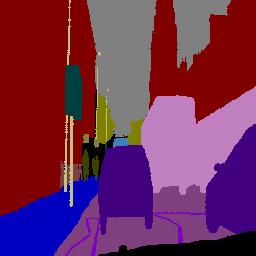

In [ ]:
mask = load_img(str(data_path) + '/train_labels/0001TP_006690_L.png', target_size=(256,256))
mask

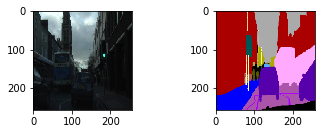

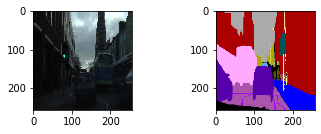

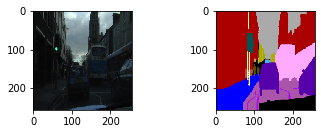

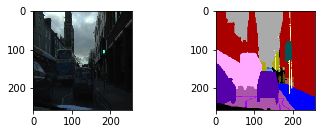

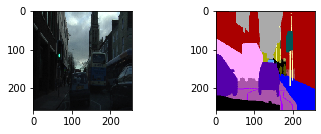

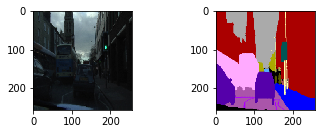

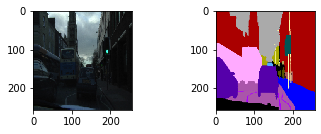

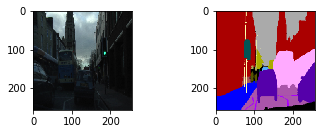

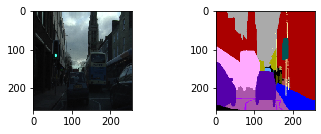

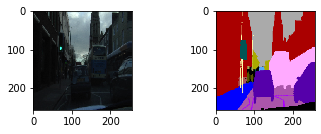

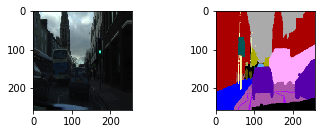

In [ ]:
# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
from keras.preprocessing.image import array_to_img, img_to_array
i = 0
img = img_to_array(img)
mask = img_to_array(mask)
for aug_img, aug_mask in zip(image_datagen.flow(np.expand_dims(img, 0), batch_size=1), mask_datagen.flow(np.expand_dims(mask, 0), batch_size=1)):
    plt.figure(i)
    plt.subplot(221)
    imgplot = plt.imshow(array_to_img(aug_img[0]))
    plt.subplot(222)
    imgplot = plt.imshow(array_to_img(aug_mask[0]))
    i += 1
    if i > 10:
        break

plt.show()

In [ ]:
model = unet(n_classes)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


Since we are doing data augmentation, we don't have a static data set, so we use the steps_per_epoch to control how many augmented samples per epoch we want. Let's have 1000.

In [ ]:
model_checkpoint = ModelCheckpoint('unet_camvid.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
model.fit_generator(train_generator_fn(),
                    validation_data=val_generator_fn(),
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=epochs,
                    callbacks=[model_checkpoint])

Epoch 1/1
1000/1000 [==============================] - 547s 547ms/step - loss: 0.8006 - acc: 0.6913 - val_loss: 0.6587 - val_acc: 0.7525

Epoch 00001: val_loss improved from inf to 0.65870, saving model to unet_camvid.hdf5


# Let's try some samples

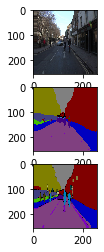

In [ ]:
img = next(val_image_generator)[0]
gt_img = next(val_mask_generator)[0]
visualize_seg(img, gt_img, gt_mode='sparse')


# Data augmentation on data in RAM

In the above we link data augmentation to data loading.

In fact they are both independent.

Data augmentation is defined in the `ImageDataGenerator` class, or any other generator using yield

The generator can be used with files on disk (data loader), if we use flow_from_directory function.

It can also be used with data in RAM, using just the flow function

Since we are calling adjust_mask inside the generator, so we need to load the raw mask, and leave the generator to do its job.

We need to modify load_CAMVID NOT to load OHE masks, but raw colors:

In [ ]:
def load_raw_CAMVID(data_type='train', enc='ohe', shape='normal'):
  img_path = str(data_path) + '/' + data_type + '/'
  labels_path = str(data_path) + '/' + data_type + '_labels/'
  # without adding target_size=(256,256) in load_img we get Out of mem: 421x960x720x32x4bytes is around 34GB!
  x = np.array([np.array(load_img(str(img_path) + file, target_size=(256,256)))*1./255 for file in sorted(os.listdir(img_path))])
  if(enc=='ohe'):
    
    y = np.array([np.array(load_img(str(labels_path) + file, target_size=(256,256))) for file in sorted(os.listdir(labels_path))])
  elif(enc=='sparse_cat'):
    y = np.array([np.array(load_img(str(labels_path) + file, target_size=(256,256))) for file in sorted(os.listdir(labels_path))])
  if(shape == 'flat'):
    y = np.reshape(y.shape[0], y.shape[1]*y.shape[2])
    y = np.expand_dims(y, axis=-1)
  return x, y

In [ ]:
import time
start = time.time()
x_train, y_train = load_raw_CAMVID(data_type='train')
#x_test, y_test = load_raw_CAMVID(data_type='test')# Don't load test for RAM consumption
x_val, y_val = load_raw_CAMVID(data_type='val')
end = time.time()
print('Time elapsed: ', end-start)

print(x_train.shape)
print(y_train.shape)
#print(x_test.shape)
#print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

Time elapsed:  19.692880153656006
(421, 256, 256, 3)
(421, 256, 256, 3)
(112, 256, 256, 3)
(112, 256, 256, 3)


__Since we scaled while loading the data, we don't need to scale in the generator__

In [ ]:
# Data generator
#batch_sz = 4
#https://keras.io/preprocessing/image/
from keras.preprocessing.image import ImageDataGenerator
# we create two instances with the same arguments

# VI Note: use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
                    #rescale=1./255)# Data is already scaled when loaded

mask_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
                    #preprocessing_function=adjust_mask)# This is not possible since the preprocessing_function can only return the same shape as image

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**mask_gen_args) 

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
#image_datagen.fit(images, augment=True, seed=seed)
#mask_datagen.fit(masks, augment=True, seed=seed)

image_generator = image_datagen.flow(
    x_train,
    seed=seed,
    batch_size=batch_sz)

mask_generator = mask_datagen.flow( 
    y_train,
    seed=seed,
    batch_size=batch_sz)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

def train_generator_fn():

    for (img,mask) in train_generator:
        new_mask = adjust_mask(mask)
        yield (img,new_mask)  
        
val_image_generator = image_datagen.flow(
    x_val,
    seed=seed,
    batch_size=batch_sz)

val_mask_generator = mask_datagen.flow(
    y_val,
    seed=seed,
    batch_size=batch_sz)

# combine generators into one which yields image and masks
val_generator = zip(val_image_generator, val_mask_generator)        
        
def val_generator_fn():

    for (img,mask) in val_generator:
        new_mask = adjust_mask(mask)
        yield (img,new_mask)         


In [ ]:
model = unet(n_classes)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


In [ ]:
model_checkpoint = ModelCheckpoint('unet_camvid.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
model.fit_generator(train_generator_fn(),
                    validation_data=val_generator_fn(),
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=epochs,
                    callbacks=[model_checkpoint])

Epoch 1/1
1000/1000 [==============================] - 389s 389ms/step - loss: 0.8239 - acc: 0.6789 - val_loss: 0.5905 - val_acc: 0.7683

Epoch 00001: val_loss improved from inf to 0.59053, saving model to unet_camvid.hdf5


# Try some samples

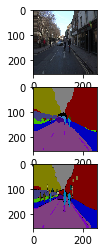

In [ ]:
img = next(val_image_generator)[0]
gt_img = next(val_mask_generator)[0]
visualize_seg(img, gt_img, gt_mode='sparse')